# Coping with Complexity: The Adaptive Value of Changing Utility


How to make choices in light of our cognitive limitations is a widely discussed issue in decision theory. Herbert Simon's "bounded rationality" approach has been highly influential and only recently (2017) has Richard Bradley published a book on this topic entitled *Decision Theory with a Human Face*.

In a 1984 Michael D. Cohen and Robert Axelrod published an unusual proposal in this debate, which has been unduly neglected. Their paper "Coping with Complexity: The Adaptive Value of Changing Utility" suggests that to deal with complexity and to overcome our limited knowledge motivational change might help. Their paper presents a case in which changing utility is adaptive, that is in which motivational change leads to better outcomes because the agents has wrong or incomplete beliefs.

Their paper has received relatively little attention given the deserved fame of its authors, but its approach invites a reconstruction in an interactive Jupyter Notebook. In the following I will walk you through the basic idea of the paper and provide some visualisation. 

### The Basic Setup

A factory manager faces a repeated choice of splitting a fixed number of labour hours between production work and maintenance work. The manager seeks to choose the level of labour devoted to production (production labour for short), which maximises the plant's output y. In addition, Cohen and Axelrod stipulate that the manager believes the following relationship to obtain:

$\hat{y}_t = -x^2_t + \hat{b}_{t-1}*x_t$

(The hats over y and b indicate that the variable tracks the believed rather than the actual output ($y$) and paramater ($b$).)

The factory manager can estimate the $\hat{b}$ given this believed relationship, a choice of $x_t$ and an observed level of output $y_t$:

$\hat{b}_{t}=y_t/x_t+x_t$ with $x_t\not= 0$

The $x_{t+1}$ maximising $\hat{y}_{t+1}$ is then given by 

$x_{t+1}=\hat{b}_t/2$

### The Error

But human agents are fallibe and so is the factory manager. Her believed production function fails to track reality accurately. Cohen and Axelrod stipulate that there is an unknown source of lost output in the factory due to pilferage. The variable $c$ $(c<0)$ will track this loss in the actual production function:

$y_t = -x^2_t + b_{t-1}*x_t+c$

We are limited beings and are unaware of all relevant variables and this leads us to make sub-optimal decisions. The factory manager will choose to devote a sub-optimal level of productive labour which leads to a negative surprise. Cohen and Axelrod model the surprise ($D$) as the difference between expected ($\hat{U}$) and actually experienced utility ($U$). For their toy model two variables govern the overall utility: the output ($y$) and the intrinsic utility for produtive labour ($w*x$).

Equation for expected utility: $\hat{U}_{t}=\hat{y}_t+w_t*x_t$ 

Equation for actual utility: $U_{t}=y_t+w_t*x_t$ 

Surprise: $D_t = U_t-\hat{U}_t$

### The Changing Utility

Cohen and Axelrod point out that the factory manager can to better by changing her utility for productive labour, that is the $w$, based on the surpise. For illustration they propose the following updating equation:

$w_{t+1}=\frac{x_t-x_{t-1}}{|x_t|} * \frac{D_t}{x_t} + w_t$

They chose this equation because it gives surprise a significant role while avoiding runaway preference change.

Of course, the preference for productive labour should also inform the decision. Accordingly we have a new updating equation for $x$:

$x_{t+1}=\hat{b}_t+w/2$

That's it. We now have an agent with changing utility. Cohen and Axelrod use a flowchart to illustrate the resulting process, which I have recreated with some simplifications.

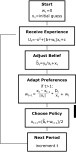

In [1]:
from IPython.display import SVG
SVG(filename='flowchart_no_text.svg')

Central for Cohen and Axelrod's purpose is that this adaptive factory manager outperforms one who keeps the utility paramter ($w$) for production labour ($x$) constant. But how should we measure the performance? If we used experienced utility as the evaluative criterion, then of course the agent who gets extra utility from productive labour would win but that's not interesting. What's interesting is that the agent undergoing motivational change and not just valuing output ($y$) might make choices that create more output. Indeed that is the case for a range of numbers and we can explore this with the following lines of Python.

In [2]:
import pandas as pd
import seaborn as sns

In [3]:
# making visualisation more beautiful
sns.set()
sns.set_style("whitegrid")

The following function lets the factory run for a few rounds.

In [4]:
def produce(w=0, x=20, b=100, b_exp=50, c=-10, adapt=False):
    if c > 0:
        print("Warning: c should be <= 0 for the model to make sense.")
    columns = pd.Index(['w', 'x', 'y', 'y_exp', 'b_exp'])
    data = pd.DataFrame(columns=columns)
        
    t = 0
    epsilon = 1
    while(epsilon > 0.1 and t < 10): # the loop runs 10 rounds or until the numbers have converged so much that there will be no further significant changes
        data.loc[t] = [None for _ in columns]
        
        # saving variables
        data['w'][t] = w
        data['x'][t] = x
        data['b_exp'][t] = b_exp
        
        # production and expected production
        data['y'][t] = -(x**2) + b*x + c
        data['y_exp'][t] = -(x**2) + b_exp*x
        
        
        # updating values for next round
        if x != 0: #avoid division by zero
            b_exp = data['y'][t]/x + x
        else:
            print("Warning: Avoided division by 0 for updating b_exp.")
        
        if adapt and t > 0: # w is updated only if adaptive.
            if x != 0:
                # Utility and expected utility are only needed to calculate the updated w
                U = data['y'][t] + w*x
                U_exp = data['y_exp'][t] + w*x
                
                w = (x-data['x'][t-1])/abs(x) \
                    * (U - U_exp)/x + w
            else:
                print("Warning: Avoided division by 0 for updating w.")
            

        x = (b_exp+w)/2
        
        # The epsilon determines whether there has been enough change to go on
        if t > 0:
            epsilon = abs(data['b_exp'][t] - data['b_exp'][t]) \
                        + abs(data['x'][t] - data['x'][t-1]) \
                        + abs(data['w'][t] - data['w'][t-1])
        t += 1 #increment number of rounds
            
    # save data from last cycle
    data['w'][-1] = w
    data['x'][-1] = x
    
    return data

The extract_y function returns the last y, that is the output achieved at the end (usually it's going to stay there).

In [5]:
def extract_y(w=0, x=20, b=100, b_exp=50, c=-10, adapt=False):
    data = produce(w, x, b, b_exp, c, adapt)
    return data['y'].iloc[-1]

For a start, we visualize the difference between the plant without and the plant with dynamic utility using the standard values and varying only parameter c (pilferage).
The other starting parameters are:
- $b=100$
- $\hat{b}_0=50$
- $x_0=20$

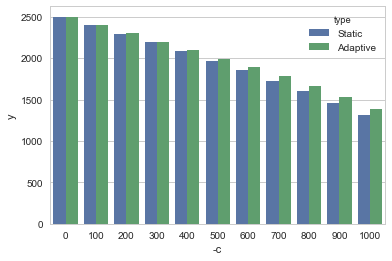

In [6]:
def visualise_performance(b=100):
    # creating the pandas DataFrame, which will be plotted
    index = pd.Index(range(20))
    columns = pd.Index(['y', '-c', 'type'])
    plot_data = pd.DataFrame(index=index, columns=columns)

    i = 0
    for c in range(0, -1100, -100):
        plot_data['-c'][i] = abs(c)
        plot_data['y'][i] = extract_y(b=b, c=c)
        plot_data['type'][i] = "Static"    
        i += 1

        plot_data['-c'][i] = abs(c)
        plot_data['y'][i] = extract_y(b=b, c=c, adapt=True)
        plot_data['type'][i] = "Adaptive"
        i += 1

    sns.barplot(x='-c', y='y', hue="type", data=plot_data)

visualise_performance()

As can be seen with the amount of pilferage the plant's output decreases, but the dynamic version does somewhat better. We can also visualise what happens if we change the parameter b.

In [7]:
from ipywidgets import widgets
widgets.interact(visualise_performance, b=(90, 210, 10))

interactive(children=(IntSlider(value=100, description='b', max=210, min=90, step=10), Output()), _dom_classes…

<function __main__.visualise_performance(b=100)>

Note that I have carefully chosen the values here. If the $b$ get's too small, the values become implausible. For example if $b$ = 50:

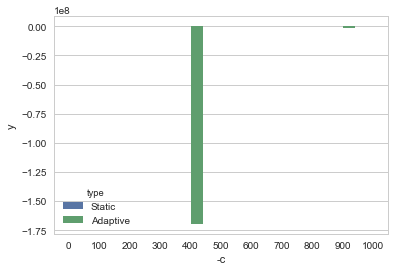

In [8]:
visualise_performance(b=50)

Nonetheless, Cohen and Axelrod have shown that for a large number of starting values the dynamic agent outperforms the static agent. Generally, whether the change of utility is adaptive depends on the ratio between the values of $c$ and the initial value of $x$. Cohen and Axelrod offer an illustrating graph on , but we can visualise the idea using a heatmap. The color of the heatmap cells indicates the ratio between the output ($y$) of the dynamic and the static factory.

In [9]:
def show_heatmap(c_values, x_values, b=100):
    
    plot_data = pd.DataFrame(index=x_values,
                         columns=c_values,
                         dtype=float)
    plot_data.index.names = ['x (initial production labour)']
    plot_data.columns.names = ['c (pilferage)']
    
    for c in c_values:
        for x in x_values:
            static_y = extract_y(c=c, x=x)
            adapt_y = extract_y(c=c, x=x, adapt=True)

            plot_data[c][x] = adapt_y / static_y
    
    sns.heatmap(plot_data)

In [10]:
def recreate_graphic():
    b = 100
    c_values = [-(b**2)//c_param for c_param in range(15, 65, 5)]
    x_values = [int(b*(x_param/5)) for x_param in range(1, 11)]
    
    show_heatmap(c_values, x_values)

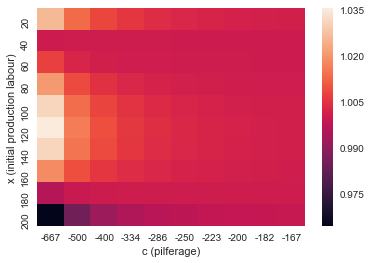

In [11]:
recreate_graphic()

Again, we can also have an interactive version (smaller for performance reasons):

In [12]:
def interactive_map(start_c=-300, start_x=50):
    c_values = [c for c in range(start_c-50*4, start_c+50, 50)]
    x_values = [x for x in range(start_x, start_x+80, 20)]
    show_heatmap(c_values, x_values)

In [13]:
widgets.interact(interactive_map, start_c=(-400, 0, 100), start_x=(10, 110, 10))

interactive(children=(IntSlider(value=-300, description='start_c', max=0, min=-400, step=100), IntSlider(value…

<function __main__.interactive_map(start_c=-300, start_x=50)>

### Conclusion

The idea behind Cohen and Axelrod's paper is simple an ingenious: We are limited beings who constantly get things wrong and neglect important variables (such as the pilferage). One way of dealing with our ignorance is to introduce another flexible part into our choice system, namely changing motivations. To show that this additional degree of freedom helps, they sketch a plausible factory example.

But that can only be the beginning. The factory is just a toy example and starts to break down for certain numbers. There remains a lot of room to improve their model

### Sources:

- Bradley, R. (2017). *Decision Theory with a Human Face*. Cambridge: Cambridge University Press.

- Cohen, M. D., & Axelrod, R. (1984). Coping with Complexity: The Adaptive Value of Changing Unity. *American Economic Review*, 74(1), 30.
